# ModSim1920: Projekt
## Planetenbahnsimulation
### von Lovis Trüstedt

## Definitionen

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

global pi
pi = 3.141592653 # Definition von PI

def sin_deg(a): return np.sin(a*(pi/180)) # Sinus für Gradzahlen
def cos_deg(a): return np.cos(a*(pi/180)) # Cosinus für Gradzahlen
def tan_deg(a): return np.tan(a*(pi/180)) # Tangenz für Gradzahlen

- $int()$ kennzeichnet ganzzahlig abgerundete Ergebnisse.<br>
- Die z-Achse ist orthogonal zur Erdbahnebene und schneidet diese an der Position der Sonne.<br>
- Viele der Werte basieren auf Beobachtung, daher ist das Ergebnis durch die beschränkte Geschwindigkeit des Lichtes für Himmelskörper in größerer Entfernung auch ungenauer.

## Die Zeit

Während die Planeten sich um die Sonne bewegen, verstreicht natürlicherweise Zeit.<br>
Da hier Planetenbahnen und nicht einfach nur die Position der Planeten zu einem bestimmten Zeitpunkt ermittelt werden sollen, muss erst einmal festgestellt werden, wie die Zeit für die spätere Berechnung der Planetenbewegungen gehandhabt wird.<br><br>
Die Einheit, welche zumeist verwendet wird, ist das julianische Datum (JD). Diese stellt die vergangene Zeit seit dem Jahr 4712 v.Chr. dar.<br><br>
Dafür müssen wir beachten, dass der gregorianische Kalender erst ab dem 15. Oktober 1582 von Papst Gregor XIII. eingeführt wurde und vorher Julius Cäsars julianischer Kalender galt. Im JD wird die gesamte Zeit vor der Kalenderreform gleich behandelt, obwohl es auch vor dem julianischen Kalender noch weitere Datumsformen gab.<br><br>
Für den gregorianischen Kalender gilt:<br>
y = Jahr, m = Monat, d = Tag<br>
Sollte der Monat Januar oder Februar sein so wird dieser als jeweils 13. oder 14. Monat des vorangegangenen Jahres interpretiert<br><br>
$$A=int(\frac{y}{100}); B=2-A+int(\frac{A}{4})$$<br>
$$JD=int(365,25(y+4716))+int(30,6001(m+1))+d+B-1524,5$$<br>
Für Daten vor der Kalenderreform gilt:
$$B=0$$
### Implementierung:

In [2]:
def julian_day(yy,mm,dd):
    if mm<3 and mm>0:
        yy = yy-1
        mm = mm+12
    A = yy//100
    if yy>1582 or (yy==1582 and (mm>10 or (mm==10 and dd >=15))): B = 2-A+A//4
    else: B=0
    return int(365.25*(yy+4716))+int(30.6001*(mm+1))+dd+B-1524.5

## Attribute der Planeten
Um die Positionen und Umlaufbahnen der Planeten auszurechnen, brauchen wir folgende sechs Attribute:<br><br>
$N=$ Länge des aufsteigenden Knotens (oft auch als großes Omega geschrieben)<br>
Diese definiert die Drehung der Schnittgraden von der Ebene der Erdbahnellipse mit der Ebene der jeweiligen Planetenbahnellipse um die z-Achse.<br><br>
$i=$ Bahnneigung in Relation zur Ebene der Erdbahn<br><br>
$w=$ Periapsisabstand (oft auch als kleines Omega geschrieben)<br>
Definiert die Rotation der Periapsis auf der jeweiligen Planetenbahnellipse<br><br>
$a=$ Länge der großen Halbachse oder auch Hauptachse in AE<br><br>
$e=$ Exzentrizität der Ellipse (für $0<=r<=1$)<br>
Diese Variable definiert die Form der Ellipse, wobei 0 kreisförmig ist und bei steigendem Wert die beiden Foci der Ellipse weiter auseinandergehen.<br><br>
$M=$ Mittlere Anomalie<br><br>
Außerdem wichtig sind:<br>
$r=$ Länge der Periapsis<br>
$L=$ Mittlere Länge (beschreibt die Position im perfekten Kreis)<br>
$T=$ Aus dem julianischen Datum errechneter Zeitfaktor<br><br>
Jedes der oben aufgeführten Attribute verändert seinen Wert mit der Zeit. Die meisten dieser Veränderungen können wir mit einer kubischen Funktion darstellen, deren Variable T die Zeit darstellt und die Faktoren a0, a1, a2 und a3 Konstanten sind, welche man vorgefertigten Tabellen zur Beschreibung von Planetenbewegungen entnehmen kann.<br>
Dies ergibt folgende kubische Funktion:
$$f(t)=a_3T^3+a_2T^2+a_1T+a_0$$
Man kann ungefähr dasselbe Ergebnis mit weniger Werten erzielen, dann ist es aber weniger genau, gilt nur für einen bestimmten Zeitraum oder sogar beides.
### Implementierung:

In [3]:
def get_curve(T,a0,a1,a2,a3): return (a3*pow(T,3))+(a2*pow(T,2))+(a1*T)+a0

damit können wir N, i, e, r, a sowie L ermitteln.<br>
Für die übrigen zwei Attribute gilt:
$$w=r-N$$ $$M=L-r$$<br>
Zudem müssen wir das julianische Datum in einen Faktor für unsere oben vorbereitete Funktion konvertieren. Diesen beschreibt die oben beschriebene Variable T.<br><br>
$$T=\frac{JD-2451545}{36525}$$
### Implementierung am Beispiel Merkur:

In [4]:
def trim_down(n): return n%360 # Funktion zur sinnvollen Kürzung von Gradzahlen
def get_timefactor(d): return (d-2451545.0)/36525 # Umrechnung des Zeitfaktors
def get_mercury(T): # Ausgabe: [N,i,w,a,e,M]
    N = get_curve(T,48.330893,1.1861883,0.00017542,0.000000215)
    r = get_curve(T,77.456119,1.5564776,0.00029544,0.000000009)
    L = get_curve(T,252.250906,149474.072249,0.0003035,0.000000018)
    return [N,
            get_curve(T,7.004986,0.0018215,-0.0000181,0.000000056),
            r-N,
            0.387098310,
           get_curve(T,0.20563175,0.000020407,-0.0000000283,-0.00000000018),
            trim_down(L-r)]

## "Planetendatenbank" - Setup
Die Implementierung von Merkur muss genauso auch auf alle anderen Planeten angewendet werden, sodass für jeden auch eine Umlaufbahn berechnet werden kann.<br>
Das folgende Chaos ist aus Liebe zur Genauigkeit entstanden.
### Implementierung:

In [5]:
def get_venus(T):
    N = get_curve(T,76.67992,0.9011206,0.00040618,-0.000000093)
    r = get_curve(T,131.563703,1.4022288,-0.000107618,-0.000005678)
    L = get_curve(T,181.979801,58519.2130302,0.00031014,0.000000015)
    return [N,get_curve(T,3.394662,0.0010037,-0.00000088,-0.000000007),r-N,0.72332982,
           get_curve(T,0.00677192,-0.000047765,0.0000000981,0.00000000046),trim_down(L-r)]
def get_mars(T):
    N = get_curve(T,49.558093,0.7720959,0.00001557,0.000002267)
    r = get_curve(T,336.060234,1.8410449,0.00013477,0.000000536)
    L = get_curve(T,355.433,19141.6964471,0.00031052,0.000000016)
    return [N,get_curve(T,1.849726,-0.0006011,0.00001276,-0.000000007),r-N,1.523679342,
           get_curve(T,0.09340065,0.000090484,-0.0000000806,-0.00000000025),trim_down(L-r)]
def get_jupiter(T):
    N = get_curve(T,100.464407,1.0209774,0.00040315,0.)
    r = get_curve(T,14.331207,1.6126352,0.00103042,-0.000004464)
    L = get_curve(T,34.351519,3036.3027748,0.0002233,0.000000037)
    a = T*0.0000001913+5.202603209
    return [N,get_curve(T,1.303267,-0.0054965,0.00000466,-0.000000002),r-N,a,
           get_curve(T,0.04849793,0.000163225,-0.0000004714,-0.00000000201),trim_down(L-r)]
def get_saturn(T):
    N = get_curve(T,113.665503,0.877088,-0.00012176,-0.000002249)
    r = get_curve(T,93.057237,1.9637613,0.00083753,0.000004928)
    L = get_curve(T,50.077444,1223.5110686,0.00051908,-0.00000003)
    a = pow(T,2)*0.000000004+T*-0.000002139+9.554909192
    return [N,get_curve(T,2.488879,-0.0037362,-0.00001519,0.000000087),r-N,a,
           get_curve(T,0.05554814,-0.0003466641,-0.0000006436,-0.0000000034),trim_down(L-r)]
def get_uranus(T):
    N = get_curve(T,74.005957,0.5211278,0.00133947,0.000018484)
    r = get_curve(T,173.005291,1.486379,0.000214,0.000000434)
    L = get_curve(T,314.055005,429.8640561,0.0003039,0.000000026)
    a = pow(T,2)*0.00000000098+T*-0.0000000372+19.218446062
    return [N,get_curve(T,0.773197,0.0007744,0.00003749,-0.000000092),r-N,a,
           get_curve(T,0.04638122,-0.000027293,0.0000000789,0.00000000024),trim_down(L-r)]
def get_neptune(T):
    N = get_curve(T,131.784057,1.1022039,0.00025952,-0.000000637)
    r = get_curve(T,48.120276,1.4262957,0.00038434,0.00000002)
    L = get_curve(T,304.348665,219.8833092,0.00030882,0.000000018)
    a = pow(T,2)*0.00000000069+T*-0.0000001663+30.110386869
    return [N,get_curve(T,1.769953,-0.0093082,-0.00000708,0.000000027),r-N,a,
           get_curve(T,0.00945575,0.000006033,0,-0.00000000005),trim_down(L-r)]

## Berechnung der exzentrischen Anomalie
Die Keplergleichung lautet:
$$M=E-e*sin(E)$$
Sie wird gebraucht um die exzentrische Anomalie E festzustellen.<br>
Mithilfe eines Computers wird sie meist folgendermaßen Approximiert:<br>
$$E=M+e*sin(M)*(1+e*cos(M))\frac{180}{\pi}$$
Da sich die exzentrische Anomalie E durch die originale Formel anders als die mittlere Anomalie M im Bogenmaß befinden würde, rechne ich hier E noch ins Gradmaß um. Daher kommt der Faktor $\frac{180}{\pi}$ am Ende der Formel.<br>
Diese eine Approximation ist aber noch nicht genau genug. Deshalb lässt man den folgenden Term solange durchiterieren, bis die Differenz zwischen dem letzten $E_{last}$ und dem aktuellen $E_{now}$ Wert klein genug ist:
$$E_{now}=E_{last}-\frac{E_{last}-e*\frac{180}{\pi}*sin(E_{last})-M}{1-e*cos(E_{last})}$$
In der folgenden Implementierung gehe ich davon aus, dass für diese Zwecke eine Genauigkeit bis auf 4 Stellen nach dem Komma reicht, man kann aber natürlich auch bis Maschinengenauigkeit iterieren.
### Implementierung:

In [6]:
def anomaly(M,e):
    last = 0
    out = M+e*sin_deg(M)*(1+e*cos_deg(M))*(180/pi)
    while abs(out-last) > 0.00001:
        last = out
        out = last-(last-e*(180/pi)*sin_deg(last)-M)/(1-e*cos_deg(last))
    return out

## Berechnung des Distanzvektors
Für die korrekte Skalierung der Bahnen ist es notwendig, einen zweidimensionalen Vektor zu errechnen, welcher auf die derzeitige Position des jeweiligen Planeten zeigt. Zweck dieses Vektors ist, anhand diesem die Distanz zur Sonne festzustellen und diese Distanz als Skalierungsfaktor zu verwenden:<br><br>
$$\left(\begin{array}{r} x \\ y \\ \end{array}\right)
=\left(\begin{array}{r}
a(cos(E)-e) \\
a(\sqrt{1-e^2}*sin(E)) \\ \end{array}\right)$$<br>
Das Ergebnis ist über den benötigten Vektor hinaus auch eine Repräsentation der Position des Planeten auf einer ungeneigten Ellipsenbahn und kann schon erste Eindrücke über den Verlauf dieser geben. Die Positionen sind auf die Zeit bezogen nicht korrekt, aber beim Plotten kann man die Elliptische Form feststellen.<br>
Von hier an ist es recht einfach die Distanz auszurechnen, da diese einfach die Länge des gerade errechneten Vektors ist:<br><br>
$$|\vec{v}|=\sqrt{x_v^2+y_v^2}$$
### Implementierung:

In [7]:
def distance_vector(a,E,e): return ( a*(cos_deg(E)-e) , a*(np.sqrt(1.0-e*e)*sin_deg(E)) )
def get_distance(v): return np.sqrt(pow(v[0],2)+pow(v[1],2))

Lässt man den Verlauf der Planetenbewegung mithilfe des zweidimensionalen Vektors plotten, kann man erste Ergebnisse sehen.
### Implementierung für Merkur und Mars für den 3. 3. 2020

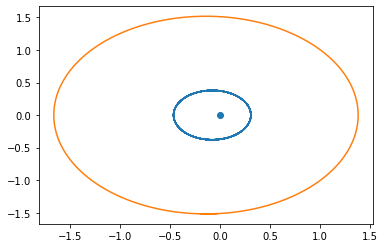

In [8]:
vxy_mercury=[]
vxy_mars=[]
d = julian_day(2020,3,3)
for i in range(0,700):
    T = get_timefactor(d-i)
    mercury = get_mercury(T)
    mars = get_mars(T)
    E = anomaly(mercury[5],mercury[4])
    vxy_mercury.append(distance_vector(mercury[3],E,mercury[4]))
    E = anomaly(mars[5],mars[4])
    vxy_mars.append(distance_vector(mars[3],E,mars[4]))
plt.scatter([0],[0]) # Position der Sonne
plt.plot([row[0] for row in vxy_mercury],[row[1] for row in vxy_mercury]) # Bahn Merkur
plt.plot([row[0] for row in vxy_mars],[row[1] for row in vxy_mars]) # Bahn Mars
plt.show()

## Berechnung der wahren Anomalie
Die wahre Anomalie v beschreibt den Winkel zwischen dem Perihel der Ellipsenbahn und dem Planeten an seiner aktuellen Position.<br>
Folgende Formel ist zur Berechnung gegeben:<br><br>
$$v=2tan^{-1}(\sqrt{\frac{1+e}{1-e}}tan(\frac{E}{2}))$$
### Implementierung:

In [9]:
def true_anomaly(e,E): return 2*np.arctan(np.sqrt((1+e)/(1-e))*tan_deg(E/2))*(180/pi)

## Attribute der Erde
Für die Erde können ein paar Vereinfachungen gemacht werden.<br>
Da die Erdbahn selbstverständlich auf der Erdbahnebene liegt gilt: $i=0$ sowie $N=0$.<br>
Daraus folgt: $w=r$<br>
Ansonsten sind aber alle Attribute der Erde wie bei jedem anderen Planeten zu behandeln.
### Implementierung:

In [10]:
def get_earth(T):
    r = get_curve(T,102.937348,1.7195366,0.00045688,-0.000000018)
    L = get_curve(T,100.466457,36000.7698278,0.00030322,0.00000002)
    return [0,0,r,1.000001018,
            get_curve(T,0.01670863,-0.000042037,-0.0000001267,0.00000000014),trim_down(L-r)]

## Position der Planeten im Koordinatensystem
Mithilfe von Standard-Rotationsmatrizen muss man um drei verschiedene Faktoren drehen:<br>
$w+v$: für die Rotation auf der Planetenbahn, mithilfe der wahren Anomalie, um die korrekte Position des Planeten zu ermitteln. Verschoben durch w, da die wahre Anomalie relativ zur Periapsis ist.<br>
$i$: für die Neigung der Planetenbahn relativ zur Ebene der Erdellipse.<br>
$N$: für die Rotation der Planetenbahn um die z-Achse.<br>
Die resultierende Matrix beschreibt nun die korrekte Rotation, jedoch muss auch die Entfernung zur Sonne stimmen. Dafür multipliziert man die Matrix einfach mit der Distanz r des zu berechnenden Planeten von der Sonne.<br>
$$\vec{r}*M_{rot}$$
Diese Multiplikation darf erst nach der Rotation ausgeführt werden, da die Skalierung vor der Rotation der Ergebnis verfälschen könnte. So auch beim Positionswechsel, der hier nicht relevant ist. Daher ist die Reihenfolge der Transformationsmatrizen immer $M_{position}*M_{skalierung}*M_{rotation}$.<br> Die Ausnahme ist, wenn man um einen anderen Punkt als den Mittelpunkt drehen will, dann ändert man zuerst die Position, da man mithilfe der Rotationsmatrix nur um $\vec{0}$ drehen kann.<br>
Das finale Ergebnis ist somit:<br><br>
$$\left(\begin{array}{r} x \\ y \\ z \\ \end{array}\right)
=\left(\begin{array}{r}
r(cos(N)*cos(v+w)-sin(N)*sin(v+w)*cos(i)) \\
r(sin(N)*cos(v+w)+cos(N)*sin(v+w)*cos(i)) \\
r(sin(v+w)*sin(i)) \\
\end{array}\right)$$
### Implementierung:

In [11]:
def cartesian_coordinates(r,N,v,w,i):
    return [r*(cos_deg(N)*cos_deg(v+w)-sin_deg(N)*sin_deg(v+w)*cos_deg(i)),
            r*(sin_deg(N)*cos_deg(v+w)+cos_deg(N)*sin_deg(v+w)*cos_deg(i)),
            r*(sin_deg(v+w)*sin_deg(i))]

## Berechnung aller Planeten
### Implementierung der Positionen von Sonne bis Mars auf den Bahnen am 3. 3. 2020:

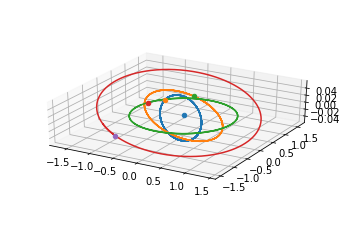

In [12]:
def calculate_planet(p):
    E = anomaly(p[5],p[4])
    vxy = distance_vector(p[3],E,p[4])
    r = get_distance(vxy)
    v = true_anomaly(p[4],E)
    return cartesian_coordinates(r,p[0],v,p[2],p[1])
def plot_planet(xyz):
    ax.scatter(xyz[0][0],xyz[0][1],xyz[0][2])
    ax.plot([row[0] for row in xyz],[row[1] for row in xyz],[row[2] for row in xyz])

neptune_xyz=[]
uranus_xyz=[]
saturn_xyz=[]
jupiter_xyz=[]
mars_xyz=[]
earth_xyz=[]
venus_xyz=[]
mercury_xyz=[]
d = julian_day(2020,3,3)
for xi in range(0,720):
    T = get_timefactor(d-xi)
    mars = get_mars(T)
    earth = get_earth(T)
    venus = get_venus(T)
    mercury = get_mercury(T)
    mars_xyz.append(calculate_planet(mars))
    earth_xyz.append(calculate_planet(earth))
    venus_xyz.append(calculate_planet(venus))
    mercury_xyz.append(calculate_planet(mercury))
for xj in range(0,60000):
    T = get_timefactor(d-xj)
    jupiter = get_jupiter(T)
    saturn = get_saturn(T)
    uranus = get_uranus(T)
    neptune = get_neptune(T)
    jupiter_xyz.append(calculate_planet(jupiter))
    saturn_xyz.append(calculate_planet(saturn))
    uranus_xyz.append(calculate_planet(uranus))
    neptune_xyz.append(calculate_planet(neptune))

fig = plt.figure()
ax = plt.gca(projection="3d")
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax),np.diag([1,1,0.4,1]))
ax.scatter([0],[0],[0])

plot_planet(mercury_xyz)
plot_planet(venus_xyz)
plot_planet(earth_xyz)
plot_planet(mars_xyz)
plt.show()

### Implementierung der Positionen von Sonne bis Neptun am 3. 3. 2020

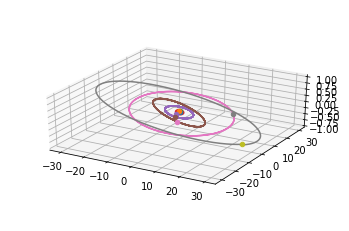

In [13]:
fig = plt.figure()
ax = plt.gca(projection="3d")
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax),np.diag([1,1,0.5,1]))
ax.scatter([0],[0],[0])

plot_planet(mercury_xyz)
plot_planet(venus_xyz)
plot_planet(earth_xyz)
plot_planet(mars_xyz)
plot_planet(jupiter_xyz)
plot_planet(saturn_xyz)
plot_planet(uranus_xyz)
plot_planet(neptune_xyz)
plt.show()

## Quellen

Buch: Jean Meeus "Astronomical Algorithms Second Edition", Richmond, Virginia 1998<br>
https://stjarnhimlen.se/comp/ppcomp.html<br>
www.davidcolarusso.com/astro<br>
Source Code von: http://cosinekitty.com/solar_system.html<br>
https://towardsdatascience.com/an-easy-introduction-to-3d-plotting-with-matplotlib-801561999725<br>
https://stackoverflow.com/questions/30223161/matplotlib-mplot3d-how-to-increase-the-size-of-an-axis-stretch-in-a-3d-plo<br>
https://de.wikipedia.org/wiki/Julianisches_Datum<br>
https://de.wikipedia.org/wiki/Gregorianischer_Kalender<br>

Wertevergleich:<br>
http://cosinekitty.com/solar_system.html<br>
http://kuffner-sternwarte.at/astronomie/sonnensystem-simulator/index.php<br>
https://www.theplanetstoday.com/the_planets.html<br>

Rechenhilfe durch GeoGebra